This is some example Python code, part of a project that involved subtracting off the point-spread function (PSF) of a quasar using another observed star (and/or model of the PSF) as well as the host galaxy's emission. The data used is from a survey of quasars taken with the Hubble Space Telescope.


All of the code was written by me.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/dclautice/hdd/Dropbox/RESEARCH/data/PKS-0920-397/HST/F475W/Observed_Star_PSF
Filename: image_drz_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     799   (1783, 1815)   float32   
  1  HDRTAB        1 BinTableHDU    631   4R x 311C   [9A, 3A, J, D, D, D, D, D, D, D, D, D, D, D, D, D, J, 7A, 9A, 7A, 18A, 4A, D, D, D, D, 3A, D, D, D, D, D, D, D, D, D, D, D, D, J, 8A, 23A, D, D, D, D, J, J, J, 8A, J, 23A, 9A, 19A, J, 1A, J, J, J, J, J, J, 23A, D, D, D, D, J, J, 3A, 3A, 4A, 7A, J, D, D, D, 23A, 1A, J, D, D, D, D, D, 4A, 4A, 12A, 12A, 23A, 8A, 23A, 10A, 10A, D, D, 3A, 3A, 23A, 4A, 8A, 7A, 3A, D, J, D, 6A, 9A, 8A, D, D, J, 4A, 18A, 3A, J, 5A, 7A, 3A, D, 13A, 8A, 4A, 3A, J, J, J, J, J, J, J, D, D, D, D, D, D, 3A, 1A, D, 23A, D, D, D, 3A, 23A, J, 1A, 3A, 1A, D, 3A, 6A, J, D, D, D, D, D, D, D, D, D, D, 23A, D, D, D, D, 3A, D, D, D, 1A, J, J, J, J,

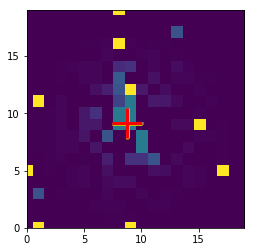

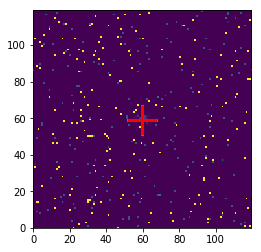

In [12]:
#Subract observed star PSF (F475W)

%load_ext autoreload
%autoreload
%matplotlib inline
#%matplotlib notebook
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import copy
from math import *
import os
import warnings
from scipy.optimize import curve_fit

from astropy.io import fits
from astropy.stats import sigma_clip
from astropy.modeling import models, fitting
from photutils import centroid_com, centroid_1dg, centroid_2dg



%cd /home/dclautice/hdd/Dropbox/RESEARCH/data/PKS-0920-397/HST/F475W/Observed_Star_PSF/
cwd = os.getcwd()
values = [['image_drz_sci.fits', 863, 970, 735, 1468]]



##################################

file_index = 0
sci_file = values[file_index][0]

hdu = fits.open(sci_file)
hdu.info()
if hdu[1].name == 'SCI':
    img_hdu = 1
else:
    img_hdu = 0
hdu.close()



#########
# Find center of Quasar (image coordinates)

hdu = fits.open(sci_file)
sci_data = hdu[img_hdu].data
size_x = hdu[img_hdu].header['NAXIS1']
size_y = hdu[img_hdu].header['NAXIS2']
print size_x, size_y
hdu.close()

radius = 10
x0_low, x0_high = values[file_index][1] - radius, values[file_index][1] + radius
y0_low, y0_high = values[file_index][2] - radius, values[file_index][2] + radius

data = sci_data[y0_low:y0_high, x0_low:x0_high]

x1, y1 = centroid_com(data)
print((x1, y1))

x2, y2 = centroid_1dg(data)
print((x2, y2))    

x3, y3 = centroid_2dg(data)
print((x3, y3))    
print((x3+x0_low+1, y3+y0_low+1))    
quasar_x = x3 + x0_low
quasar_y = y3 + y0_low



x1, y1 = centroid_com(data)
x2, y2 = centroid_1dg(data)
x3, y3 = centroid_2dg(data)
fig, ax = plt.subplots(1, 1)
ax.imshow(data, origin='lower', vmin=0.1, vmax=100)
marker = '+'
ms, mew = 30, 3.
plt.plot(x1, y1, color='cyan', marker=marker, ms=ms, mew=mew)
plt.plot(x2, y2, color='y', marker=marker, ms=ms, mew=mew)
plt.plot(x3, y3, color='r', marker=marker, ms=ms, mew=mew)
ax.set_xlim(0, data.shape[1]-1)
ax.set_ylim(0, data.shape[0]-1)

############


###############
#Find center of stellar PSF (image coordinates) in the same image

radius = 60

xmin = values[file_index][3]-radius
xmax = values[file_index][3]+radius
ymin = values[file_index][4]-radius
ymax = values[file_index][4]+radius
print xmin, xmax, ymin, ymax


!rm psf.fits

hdu = fits.open(sci_file)
hdu[img_hdu].data = hdu[img_hdu].data[ymin:ymax, xmin:xmax]
hdu.writeto('psf.fits', overwrite=True)
hdu.close()


hdu = fits.open(sci_file)
sci_data = hdu[img_hdu].data
hdu.close()

x0_low, x0_high = values[file_index][3] - radius, values[file_index][3] + radius
y0_low, y0_high = values[file_index][4] - radius, values[file_index][4] + radius
print x0_low, x0_high, y0_low, y0_high

data = sci_data[y0_low:y0_high, x0_low:x0_high]

x1, y1 = centroid_com(data)
print((x1, y1))

x2, y2 = centroid_1dg(data)
print((x2, y2))    

x3, y3 = centroid_2dg(data)
print((x3, y3))    
print((x3+x0_low+1, y3+y0_low+1))
psf_x = x3
psf_y = y3

x1, y1 = centroid_com(data)
x2, y2 = centroid_1dg(data)
x3, y3 = centroid_2dg(data)
fig, ax = plt.subplots(1, 1)
ax.imshow(data, origin='lower', vmin=0.1, vmax=100)
marker = '+'
ms, mew = 30, 3.
plt.plot(x1, y1, color='cyan', marker=marker, ms=ms, mew=mew)
plt.plot(x2, y2, color='y', marker=marker, ms=ms, mew=mew)
plt.plot(x3, y3, color='r', marker=marker, ms=ms, mew=mew)
ax.set_xlim(0, data.shape[1]-1)
ax.set_ylim(0, data.shape[0]-1)

##########


############
# Subtract off background from PSF

from astropy.stats import sigma_clipped_stats
from photutils import make_source_mask

mask = make_source_mask(sci_data, snr=3, npixels=5, dilate_size=5)
mean, median, std = sigma_clipped_stats(sci_data, sigma=2.0, iters=5, mask=mask)
#mean, median, std = sigma_clipped_stats(data, sigma=3.0, iters=5)
print((mean, median, std))


psf_hdu = fits.open('psf.fits')
psf_hdu[0].data = psf_hdu[0].data - median
psf_hdu.writeto('psf_bgsub.fits', overwrite=True)
psf_hdu.close()


############
# Align and subtract PSF from Quasar

iraf.unlearn(iraf.imlintran)
iraf.imlintran.input = 'psf_bgsub.fits'
iraf.imlintran.output = 'psf_trans.fits'
iraf.imlintran.xrotation = '0'
iraf.imlintran.yrotation = '0'
iraf.imlintran.xin = str(psf_x+2)
iraf.imlintran.yin = str(psf_y+2)
iraf.imlintran.xout = str(quasar_x+1+1)
iraf.imlintran.yout = str(quasar_y+1+0.8)
iraf.imlintran.ncols = str(size_x)
iraf.imlintran.nlines = str(size_y)
iraf.imlintran.interpolant = 'drizzle'
iraf.imlintran.boundary = 'constant'
iraf.imlintran.constant = 0
iraf.imlintran()
print quasar_x, quasar_y, psf_x, psf_y


print 'size', size_x, size_y
sci_hdu = fits.open(sci_file)
psf_hdu = fits.open('psf_trans.fits')
sci_data = sci_hdu[img_hdu].data
psf_data = psf_hdu[0].data
radius = 4
x0_low, x0_high = values[file_index][1] - radius, values[file_index][1] + radius
y0_low, y0_high = values[file_index][2] - radius, values[file_index][2] + radius
data = sci_data[y0_low:y0_high, x0_low:x0_high]
psf_subset = psf_data[y0_low:y0_high, x0_low:x0_high]
print np.max(data)
print np.max(psf_subset)
print np.max(data) / np.max(psf_subset)
print np.sum(data) / np.sum(psf_subset)
#sci_hdu[img_hdu].data = sci_data - 1 * psf_data * np.max(data) / np.max(psf_subset)
# sci_hdu[img_hdu].data = sci_data - 1 * psf_data * np.max(data) / np.max(psf_data)
sci_hdu[img_hdu].data = sci_data - 1.2 * psf_data * np.sum(data) / np.sum(psf_subset)
#sci_hdu[img_hdu].data = sci_data - psf_data * 10000
sci_hdu.writeto('PKS-0920-397_F475W_drz_psfsub.fits', overwrite=True)

sci_hdu.close()
psf_hdu.close()


## Result

The image below shows the quasar before and after subtracting off the observed PSF.

On the left, the diffraction of incoming light when it interacts with the telescope causes the very bright quasar to spread some of its light out in a particular pattern (called a PSF). Comparing the before and after images, we can see now that there is a bright component of light that is not associated with the quasar just to the south. This is an optical component of a quasar jet, which is the object we wish to study.

From here, we would then calculate the flux and statistics of the jet component and compare with images taken in other wavelengths.

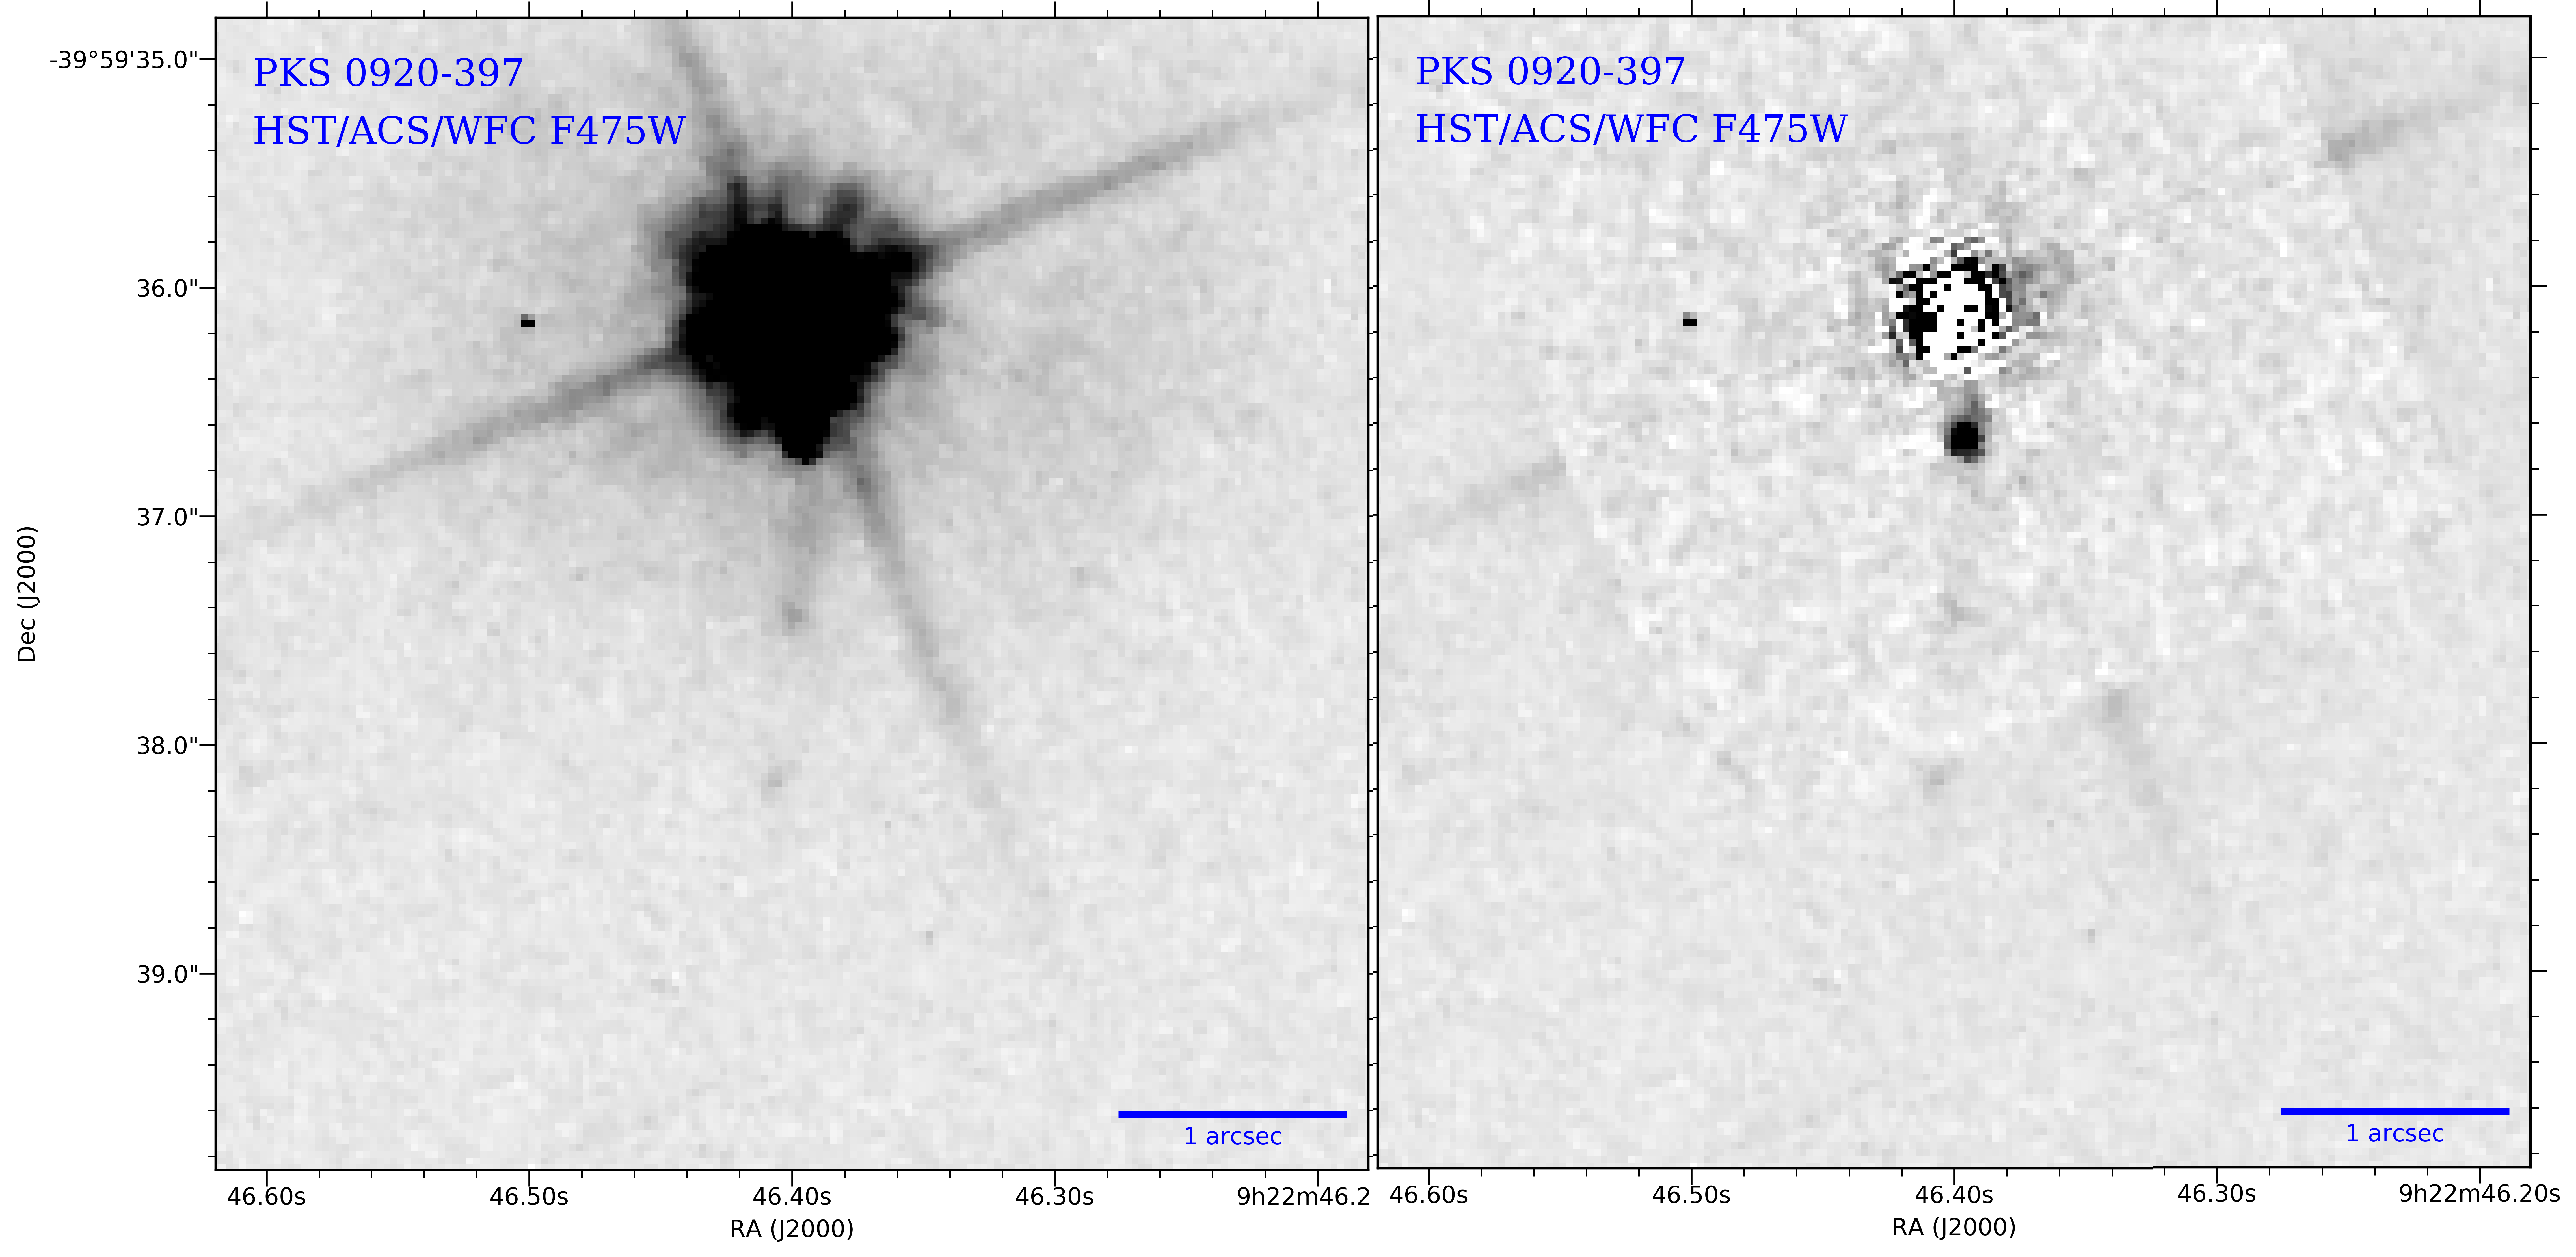

# Galaxy Subtraction

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

#from pylab import *
from __future__ import division
import numpy as np
from math import *

import os
import os.path

# Set to location of login.cl
os.chdir("/home/dclautice/")
import pyraf
from pyraf import iraf
from pyraf.iraf import stsdas, analysis, isophote
from pyraf.iraf import tables, ttools

# Set to working directory
os.chdir("/home/dclautice/Dropbox/RESEARCH/ellipse_nuker/3C111/")
suffix = '_21'

In [3]:
# We use IRAF (Image Reduction and Analysis Facility) to generate isophotes of the galaxy emission

iraf.unlearn(iraf.geompar)
#iraf.lpar('geompar')
iraf.geompar.x0 = 1473.380
iraf.geompar.y0 = 1255.072
iraf.geompar.ellip0 = 0.20
iraf.geompar.pa0 = 20
iraf.geompar.sma0 = 1700
iraf.geompar.minsma = 10
#iraf.geompar.maxsma = 81.18
iraf.geompar.step = 0.1
iraf.geompar.linear = "no"
iraf.geompar.recenter = "no"

iraf.unlearn(iraf.controlpar)
iraf.controlpar.maxit = '200'
iraf.controlpar.hcenter = "yes"
iraf.controlpar.hellip = "no"
iraf.controlpar.hpa = "no"

iraf.unlearn(iraf.samplepar)
iraf.unlearn(iraf.magpar)

iraf.unlearn(iraf.ellipse)
#iraf.lpar('ellipse')
iraf.ellipse.input = '3c111_f160w_skymatch_drz_crval.fits[1]'
iraf.ellipse.output = '3c111_f160w_skymatch_ellipse'+suffix+'.tab'
iraf.ellipse.dqf = '3c111_f160w_mask_2.pl'
iraf.ellipse()

Running object locator... Done.
#
# Semi-    Isophote      Ellipticity     Position   Grad.  Data Flag Iter. Stop
# major      mean                         Angle      rel.                  code
# axis     intensity                                error
#(pixel)                                 (degree)
#
1700.00     0.42(  0.01) 0.200(0.395)  20.00( 2.91) INDEF  101 9381     1    1
1545.45     0.42(  0.01) 0.200(0.018)  20.00( 0.21) INDEF  304 8316     1    1
1404.96     0.41(  0.01) 0.200(0.002)  20.00( 0.04) INDEF  600 7237     1    1
1277.24     0.41(  0.01) 0.200(0.000)  20.00( 0.00) INDEF 1492 5632     1    1
1161.12     0.41(  0.01) 0.200(0.000)  20.00( 0.00) INDEF 1823 4654     1    1
1055.57     0.41(  0.01) 0.200(0.000)  20.00( 0.01) INDEF 1447 4441     1    1
 959.61     0.41(  0.01) 0.200(0.000)  20.00( 0.01) INDEF 1733 3620     1    1
 872.37     0.41(  0.01) 0.200(0.000)  20.00( 0.01) INDEF 2145 2721     1    1
 793.06     0.41(  0.01) 0.200(0.000)  20.00( 0.01) INDEF 2078 2

In [5]:
# Convert the isophote data into an image and table

iraf.unlearn(iraf.bmodel)
iraf.bmodel.table = '3c111_f160w_skymatch_ellipse'+suffix+'.tab'
iraf.bmodel.output = '3c111_f160w_skymatch_bmodel'+suffix+'.fits'
iraf.bmodel()

iraf.unlearn(iraf.imarith)
iraf.imarith.operand1 = '3c111_f160w_skymatch_drz_crval.fits[1]'
iraf.imarith.op = '-'
iraf.imarith.operand2 = '3c111_f160w_skymatch_bmodel'+suffix+'.fits'
iraf.imarith.result = '3c111_f160w_skymatch_sub'+suffix+'.fits'
iraf.imarith()

#iraf.lpar('tprint')
iraf.unlearn(iraf.tprint)
iraf.tprint.table = '3c111_f160w_skymatch_ellipse'+suffix+'.tab'
iraf.tprint.columns = 'SMA, INTENS'
#iraf.tprint()

iraf.unlearn(iraf.tdump)
iraf.tdump.table = '3c111_f160w_skymatch_ellipse'+suffix+'.tab'
iraf.tdump.cdfile = 'ellipse_columns'+suffix+'.txt'
iraf.tdump.pfile = 'ellipse_headers'+suffix+'.txt'
iraf.tdump.datafile = 'ellipse_data'+suffix+'.txt'
#iraf.tdump.columns = 'SMA, INTENS'
iraf.tdump()

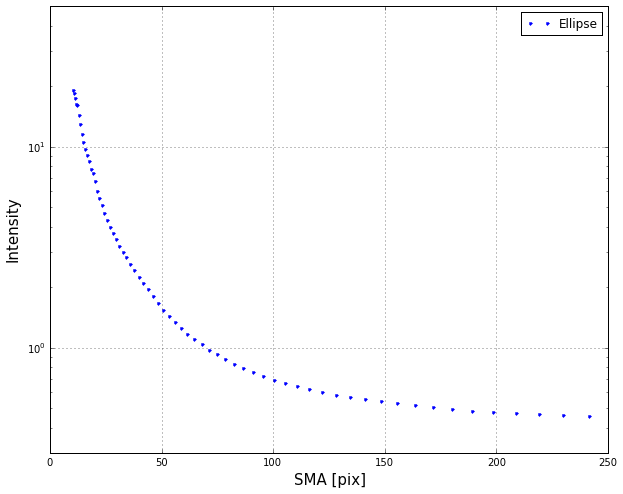

In [4]:
# Generate a plot of the galaxy's emission profile

data = np.genfromtxt('ellipse_data'+suffix+'.txt')
sma = data[:,0]
intens = data[:,1]

fig = plt.figure(figsize=(10,8), dpi = 200)
ax = fig.add_subplot(1, 1, 1, yscale='log')
ax.set_xlim([0, 250])
ax.set_ylim([0.3, 50])
ax.grid(linewidth=0.5)
plt.plot(sma, intens, 'b.', label='Ellipse')
plt.legend(loc='upper right')
plt.xlabel('SMA [pix]', fontsize='15')
plt.ylabel('Intensity', fontsize='15')

plt.show()


The process of fitting isophotes to the galaxy's emission is not perfect. The residual image will show "ring" patterns where the model under- or over-estimates the brightness. To remedy that, we fit a model to the data using a standard mathematical function, either a Sersic model or a Nuker model (i.e. https://en.wikipedia.org/wiki/Sersic_profile )

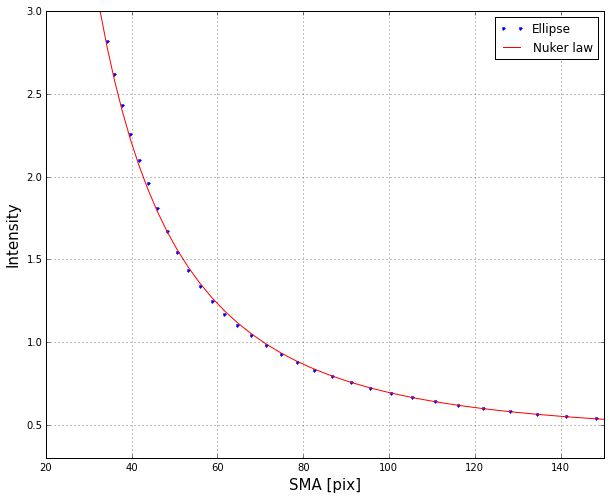

In [57]:
def func(x,I,a,b,g,rb):
    return I*2**((b-g)/a)*(x/rb)**(-g)*(1+(x/rb)**(a))**((g-b)/a)

sma_cut = []
intens_cut = []

sma_cut = sma[15:75]
intens_cut = intens[15:75]

guess = [1, 0.3, 3, 1, 100]
popt, pconv = curve_fit(func, sma_cut, intens_cut, guess, maxfev = 5000)


x = sma
I = popt[0]
a = popt[1]
b = popt[2]
g = popt[3]
rb = popt[4]

intens_model = I*2**((b-g)/a)*(x/rb)**(-g)*(1+(x/rb)**(a))**((g-b)/a)

fig = plt.figure(figsize=(10,8), dpi = 600)
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim([20, 150])
ax.set_ylim([0.3, 3])
ax.grid(linewidth=0.5)
plt.plot(sma, intens, 'b.', label='Ellipse')
plt.plot(sma, intens_model, 'r-', label='Nuker law')
plt.legend(loc='upper right')
plt.xlabel('SMA [pix]', fontsize='15')
plt.ylabel('Intensity', fontsize='15')

plt.show()

## Result

You can see in the above plot where the model predicts higher or lower intensity than the data. Updating the isophotes using the model's output gives us a smooth galaxy profile that we can then easily subtract from the original image. Doing so allows us to better-analyze the light from the jet itself.

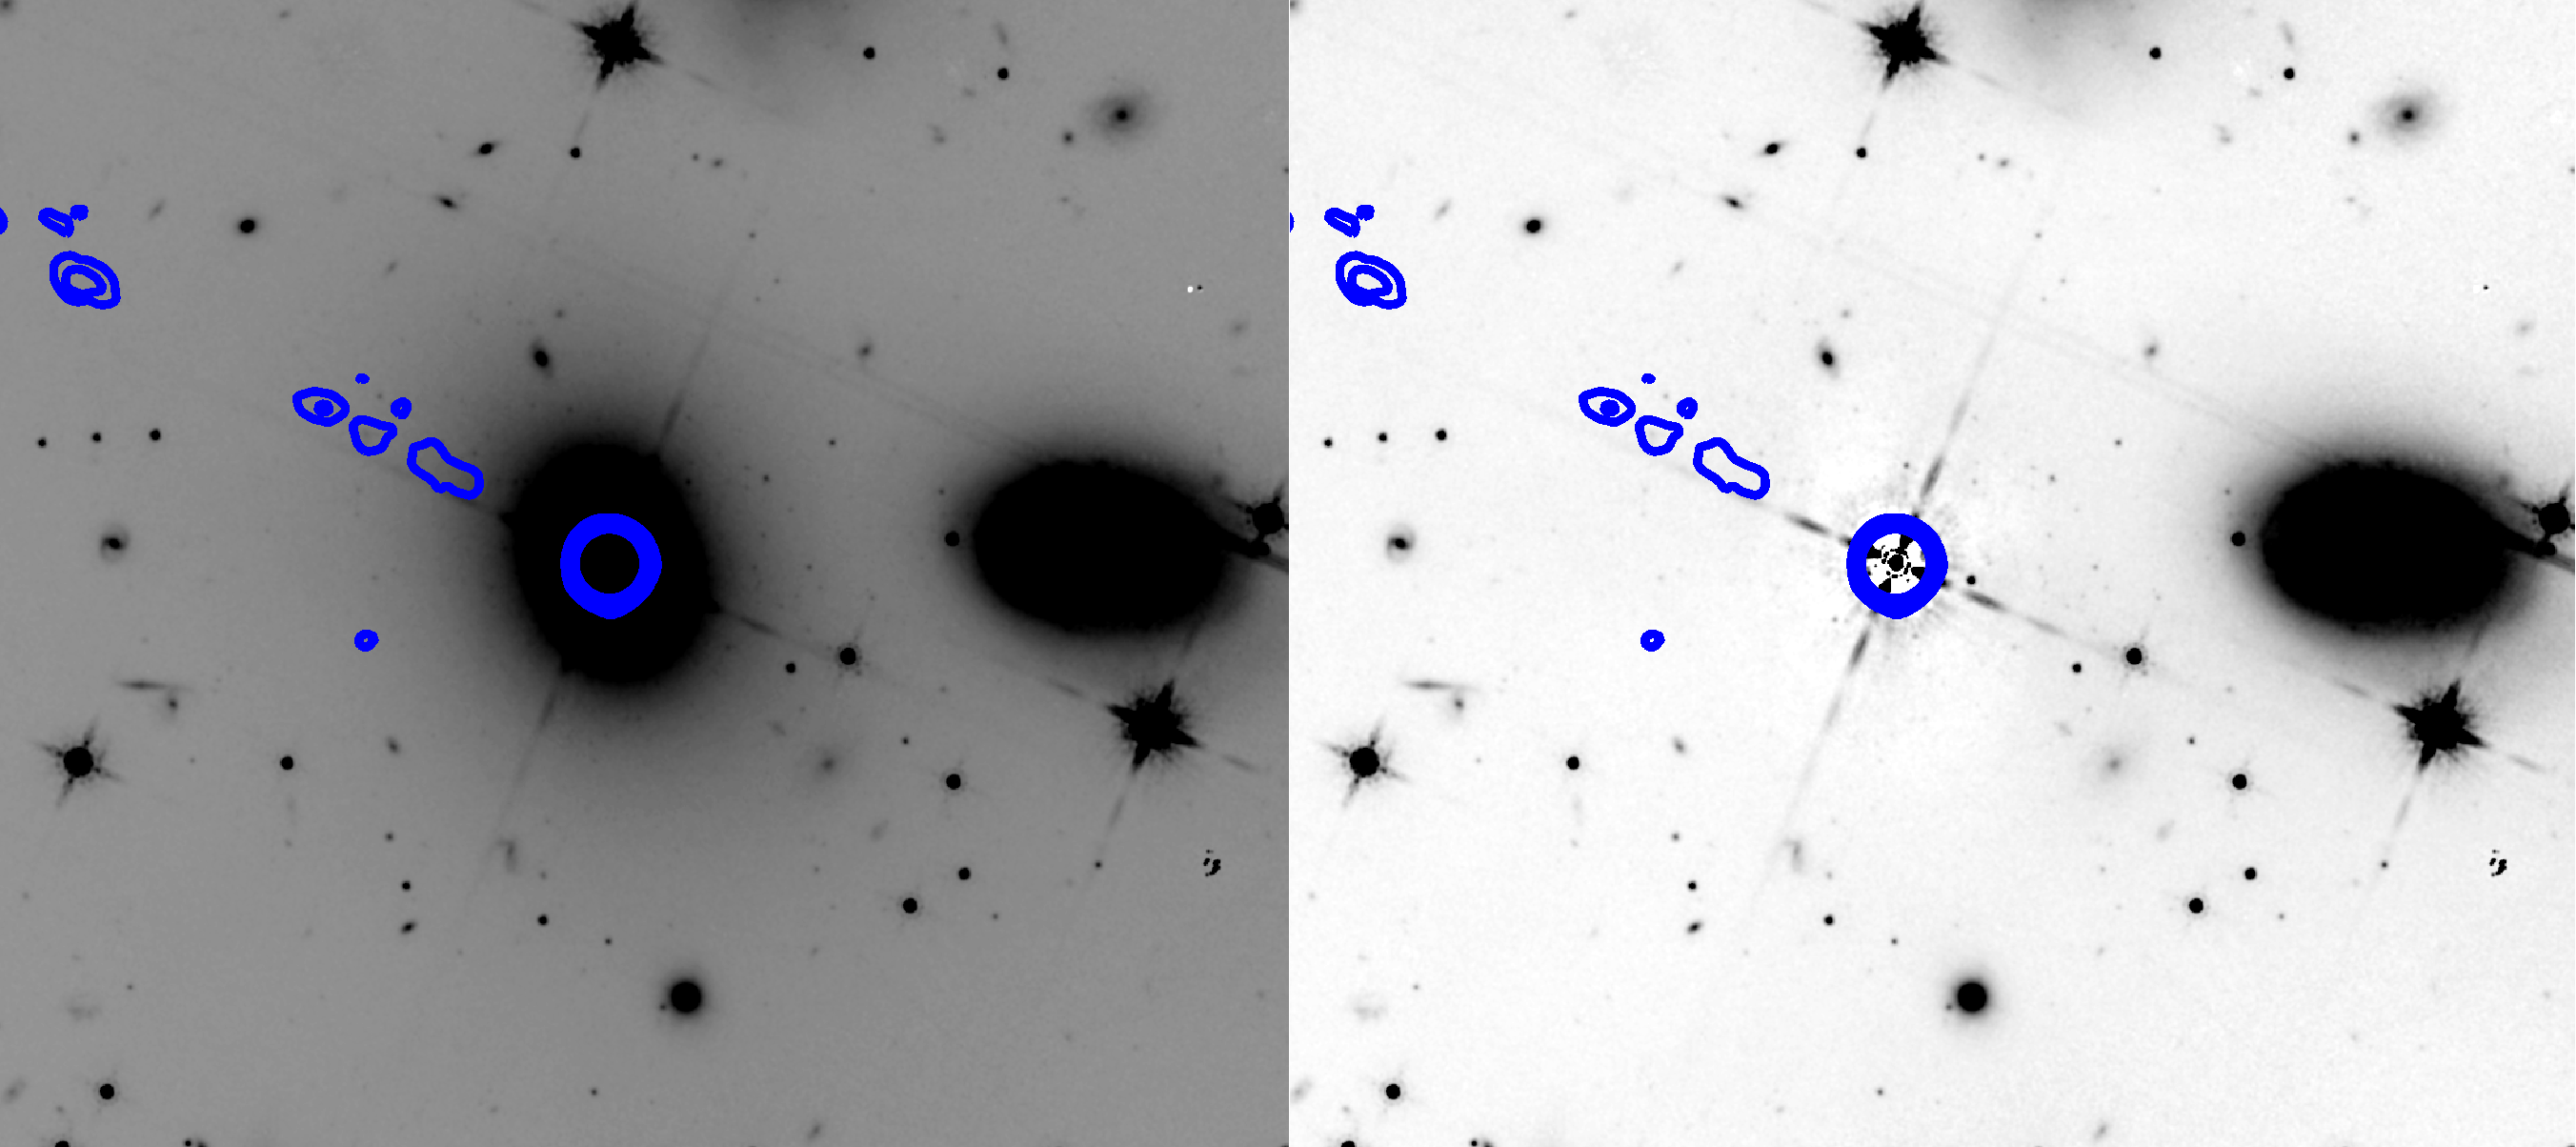